In [1]:
import numpy as np
import pyproj
import matplotlib.pyplot as plt
import torch

from OkadaTorch import OkadaWrapper
okada = OkadaWrapper()

# Generate observation data (synthetic data + some noise)

In [ ]:
# domain
lon_min, lon_max = 142, 148
lat_min, lat_max = 37, 43
dlon, dlat = 0.25, 0.25 # very sparse
nlon, nlat = int((lon_max-lon_min)/dlon)+1, int((lat_max-lat_min)/dlon)+1
lon_mid, lat_mid = (lon_min+lon_max)/2, (lat_min+lat_max)/2


# coordinate transformation
ll2xy = pyproj.Transformer.from_crs(
    crs_from="EPSG:4326", # WGS84
    crs_to=f"+proj=tmerc +lon_0={lon_mid} +lat_0={lat_mid} +ellps=WGS84 +datum=WGS84 +units=km", 
    always_xy=True
)

lon = np.linspace(lon_min, lon_max, nlon)
lat = np.linspace(lat_min, lat_max, nlat)
Lon, Lat = np.meshgrid(lon, lat)
x_obs, y_obs = ll2xy.transform(Lon, Lat)
X_obs = torch.from_numpy(x_obs)
Y_obs = torch.from_numpy(y_obs)

coords = {
    "x": X_obs,
    "y": Y_obs
}


# source parameters
lat_ref = 40.2224
lon_ref = 144.8678
x_ref, y_ref = ll2xy.transform(lon_ref, lat_ref)

print(x_ref, y_ref) # km

params_true = {
    "x_ref": torch.tensor(x_ref),
    "y_ref": torch.tensor(y_ref),
    "depth": torch.tensor(0.1), # km
    "length": torch.tensor(218.0), # km
    "width": torch.tensor(46.0), # km
    "strike": torch.tensor(189.0), # degree
    "dip": torch.tensor(60.0), # degree
    "rake": torch.tensor(270.0), # degree
    "slip": torch.tensor(5.62) # m
}

ux_obs, uy_obs, uz_obs = okada.compute(coords, params_true, compute_strain=False, is_degree=True) 

-11.25235992480785 24.70296061567198


In [3]:
print("True paramters:")

for name in params_true.keys():
    value = params_true[name].item()
    print(name, value)

True paramters:
x_ref -11.252360343933105
y_ref 24.702960968017578
depth 0.10000000149011612
length 218.0
width 46.0
strike 189.0
dip 60.0
rake 270.0
slip 5.619999885559082


In [4]:
rng = np.random.default_rng(seed=123)
err = 0.05 * rng.standard_normal((nlon, nlat, 3))

ux_obs += err[:, :, 0]
uy_obs += err[:, :, 1]
uz_obs += err[:, :, 2]

/tmp/ipykernel_1772519/3372770884.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ux_obs += err[:, :, 0]
/tmp/ipykernel_1772519/3372770884.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  uy_obs += err[:, :, 1]
/tmp/ipykernel_1772519/3372770884.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  uz_obs += err[:, :, 2]


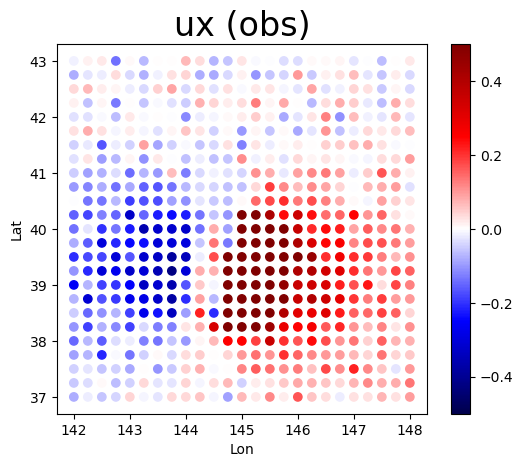

In [5]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=ux_obs, cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("ux (obs)", fontsize=24)
fig.colorbar(im)
fig.show()

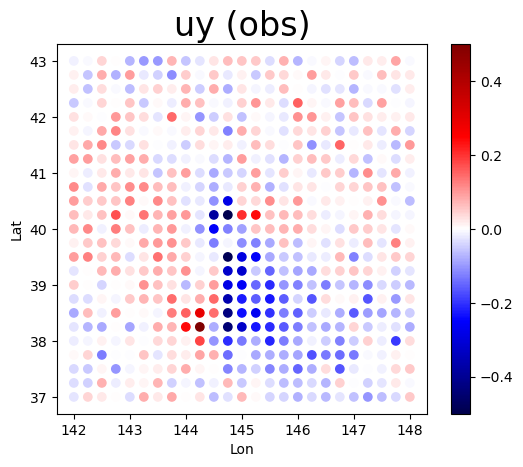

In [6]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uy_obs, cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uy (obs)", fontsize=24)
fig.colorbar(im)
fig.show()

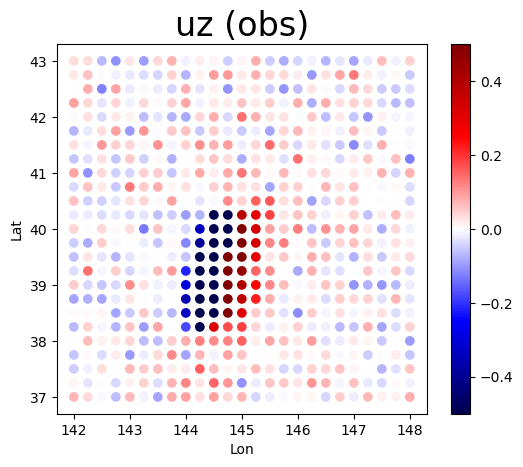

In [7]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uz_obs, cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uz (obs)", fontsize=24)
fig.colorbar(im)
fig.show()

# Gradient-based parameter estimation


For the optimizer to work well, it is desirable for the gradients with respect to each parameter to have the same order of magnitude.
Here, we perform the simplest scaling, i.e. normalization by dividing by a constant.
But this is just one of the methods to deal with it.

- For the variables with an angle dimension, unlike the previous notebooks, they will be expressed in radian rather than degree, so that the value will have an order of $\pi$, rather 180.
- Variables with a length dimension (except for `slip`) should also be of this order. As we see in the next cell, both `X_obs` and `Y_obs` are roughly in the range of -300 km to 300 km. Therefore, we further divide by 100 so that the units are 100 km.

## Scaling `x` and `y`



In [8]:
print(X_obs.min(), X_obs.max())
print(Y_obs.min(), Y_obs.max())

# scaled coordinate values (not optimized; DO NOT SPECIFY `requires_grad=True`)
coords = {
    "x": X_obs/1e2, # new unit = 100km
    "y": Y_obs/1e2,
}

tensor(-267.0689, dtype=torch.float64) tensor(267.0689, dtype=torch.float64)
tensor(-333.0181, dtype=torch.float64) tensor(337.5607, dtype=torch.float64)


### NOTE

For some parameters (especially `x_ref` and `y_ref`), choise of initial values can greatly affect the results;
if they are chosen too far from the optimal values, the optimizer will fail (the solution will diverge). 
In practical cases, it may be safer to keep those variables fixed at some values (+ set `requires_grad=False`) and optimize only the other parameters.

The purpose here is only to demonstrate conceptually that optimization is possible using gradients obtained by automatic differentiation.
Actual applications would require more techniques.

In [9]:
# initial values of parameters (SPECIFY `requires_grad=True` !)
params = {
    "x_ref": torch.tensor(-11/1e2, requires_grad=True),  
    "y_ref": torch.tensor(+24/1e2, requires_grad=True),
    "depth": torch.tensor(1/1e2, requires_grad=True),
    "length": torch.tensor(200/1e2, requires_grad=True),
    "width": torch.tensor(50/1e2, requires_grad=True),
    "strike": torch.tensor(200*torch.pi/180, requires_grad=True),
    "dip": torch.tensor(45*torch.pi/180, requires_grad=True),
    "rake": torch.tensor(300*torch.pi/180, requires_grad=True),
    "slip": torch.tensor(5.0, requires_grad=True)
}

print("Initial values:")

for name in params.keys():
    value = params[name].item()
    if name in ["x_ref", "y_ref", "depth", "length", "width"]:
        print(name, value*1e2)
    elif name in ["strike", "dip", "rake"]:
        print(name, value*180/np.pi)
    else:
        print(name, value)

Initial values:
x_ref -10.999999940395355
y_ref 23.999999463558197
depth 0.9999999776482582
length 200.0
width 50.0
strike 200.0000010120476
dip 45.00000125223908
rake 299.99999468788224
slip 5.0


In [ ]:
niter = 1000

optimizer = torch.optim.Adam(
    [p for p in params.values() if p.requires_grad],
)


def closure():
    ux, uy, uz = okada.compute(coords, params, compute_strain=False, is_degree=False)
    res1 = ux - ux_obs
    res2 = uy - uy_obs
    res3 = uz - uz_obs
    loss = 0.5 * (res1 * res1 + res2 * res2 + res3 * res3).sum()
    optimizer.zero_grad()
    loss.backward()
    return loss


for iter in range(niter):
    optimizer.step(closure)
    loss = closure()

    print(f"Iteration {iter}: Loss = {loss.item()}")

Iteration 0: Loss = 66.17664622816103
Iteration 1: Loss = 65.45810406199833
Iteration 2: Loss = 64.72582249141244
Iteration 3: Loss = 63.97519539635927
Iteration 4: Loss = 63.20232392364737
Iteration 5: Loss = 62.40493735567265
Iteration 6: Loss = 61.583557885005575
Iteration 7: Loss = 60.74330223635852
Iteration 8: Loss = 59.89584872715942
Iteration 9: Loss = 59.06001400509239
Iteration 10: Loss = 58.259859398659
Iteration 11: Loss = 57.51719661332595
Iteration 12: Loss = 56.84102608208254
Iteration 13: Loss = 56.220522953888874
Iteration 14: Loss = 55.63052002927237
Iteration 15: Loss = 55.04492761259137
Iteration 16: Loss = 54.44631720270297
Iteration 17: Loss = 53.82734305929115
Iteration 18: Loss = 53.18797046740494
Iteration 19: Loss = 52.53250088975348
Iteration 20: Loss = 51.86749153051449
Iteration 21: Loss = 51.20008035263708
Iteration 22: Loss = 50.53659056783582
Iteration 23: Loss = 49.88186543602218
Iteration 24: Loss = 49.238612068576586
Iteration 25: Loss = 48.6075792592

In [11]:
print("Final results:")

for name in params.keys():
    true = params_true[name].item()
    pred = params[name].item()
    if name in ["x_ref", "y_ref", "depth", "length", "width"]:
        print(f"[{name}] {true} vs {pred*1e2}")
    elif name in ["strike", "dip", "rake"]:
        print(f"[{name}] {true} vs {pred*180/np.pi}")
    else:
        print(f"[{name}] {true} vs {pred}")

Final results:
[x_ref] -11.252360343933105 vs -10.505853593349457
[y_ref] 24.702960968017578 vs 24.972856044769287
[depth] 0.10000000149011612 vs 0.05430048913694918
[length] 218.0 vs 217.97568798065186
[width] 46.0 vs 47.60270118713379
[strike] 189.0 vs 189.2414558616587
[dip] 60.0 vs 59.78608014484731
[rake] 270.0 vs 269.8369230866221
[slip] 5.619999885559082 vs 5.423550605773926


In [ ]:
coords = {
    "x": X_obs/1e2,
    "y": Y_obs/1e2,
}
ux, uy, uz = okada.compute(coords, params, compute_strain=False, is_degree=False)

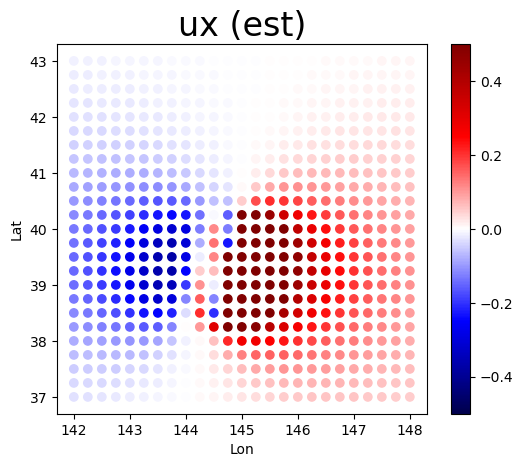

In [13]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=ux.detach(), cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("ux (est)", fontsize=24)
fig.colorbar(im)
fig.show()

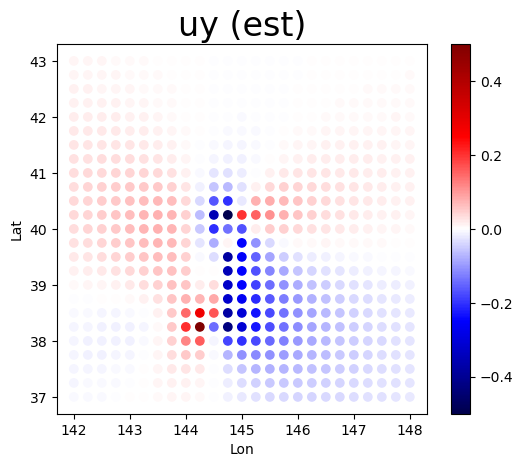

In [14]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uy.detach(), cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uy (est)", fontsize=24)
fig.colorbar(im)
fig.show()

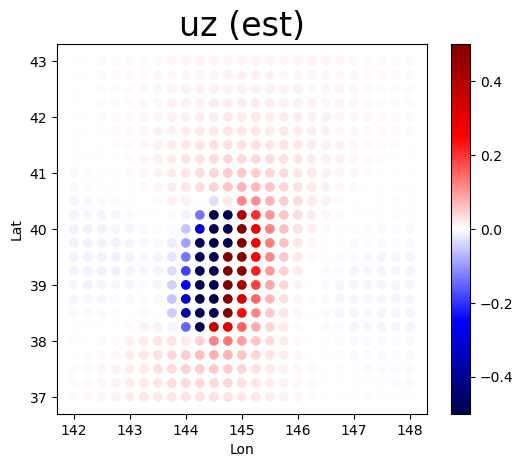

In [15]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uz.detach(), cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uz (est)", fontsize=24)
fig.colorbar(im)
fig.show()